Article: https://www.embedded-robotics.com/\
Code: Image Classification using Convolution Neural Network\
Prepared By: Awais Naeem (awais.naeem@embedded-robotics.com)\
Copyrights: www.embedded-robotics.com\
Disclaimer: This code can be distributed with the proper mention of the owner copyrights

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.optim as optim
from sklearn.metrics import accuracy_score
from skimage.io import imread
from skimage.transform import resize

Intel Data: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [2]:
home = os.path.expanduser('~')

In [3]:
classes_dict = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}

In [4]:
train_data_path = os.path.join(home, ".torch/datasets/intel/seg_train/seg_train")
test_data_path = os.path.join(home, ".torch/datasets/intel/seg_test/seg_test")

In [5]:
train_X = []
train_y = []
for (out_class, out_label) in classes_dict.items():
    class_path = os.path.join(train_data_path, out_class)
    class_img_list = os.listdir(class_path)
    
    for img_name in class_img_list:
        img_path = os.path.join(class_path, img_name)
        img = imread(img_path)
        img = img/255.0
        img = resize(img, (150,150,3), anti_aliasing=True)
        img = img.astype('float32')
        train_X.append(img)
        train_y.append(out_label)

In [6]:
test_X = []
test_y = []
for (out_class, out_label) in classes_dict.items():
    class_path = os.path.join(test_data_path, out_class)
    class_img_list = os.listdir(class_path)
    
    for img_name in class_img_list:
        img_path = os.path.join(class_path, img_name)
        img = imread(img_path)
        img = img/255.0
        img = resize(img, (150,150,3), anti_aliasing=True)
        img = img.astype('float32')
        test_X.append(img)
        test_y.append(out_label)

In [7]:
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

In [8]:
print('Train X:', train_X.shape)
print('Train y:', train_y.shape)
print('Train X:', test_X.shape)
print('Train y:', test_y.shape)

Train X: (14034, 150, 150, 3)
Train y: (14034,)
Train X: (3000, 150, 150, 3)
Train y: (3000,)


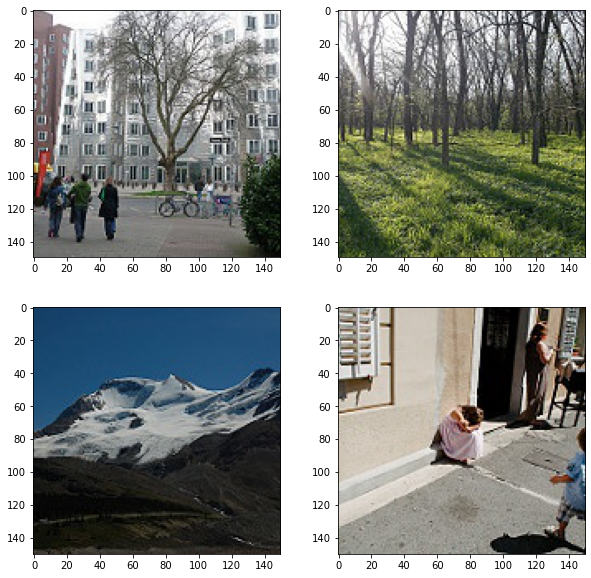

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(train_X[0], cmap='gray')
plt.subplot(222)
plt.imshow(train_X[3000], cmap='gray')
plt.subplot(223)
plt.imshow(train_X[6000], cmap='gray')
plt.subplot(224)
plt.imshow(train_X[12000], cmap='gray')
plt.show()

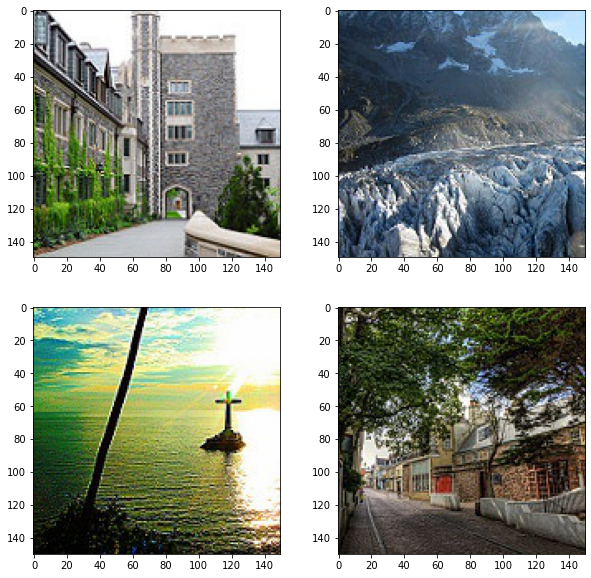

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(test_X[0], cmap='gray')
plt.subplot(222)
plt.imshow(test_X[1000], cmap='gray')
plt.subplot(223)
plt.imshow(test_X[2000], cmap='gray')
plt.subplot(224)
plt.imshow(test_X[2500], cmap='gray')
plt.show()

In [11]:
tensor_train_X = torch.from_numpy(train_X).float()
tensor_train_y = torch.from_numpy(train_y).long()
tensor_test_X = torch.from_numpy(test_X).float()
tensor_test_y = torch.from_numpy(test_y).long()

In [12]:
tensor_train_X = tensor_train_X.permute((0,3,1,2))
tensor_test_X = tensor_test_X.permute((0,3,1,2))

In [13]:
print('Tensor Train:', tensor_train_X.shape)
print('Tensor Test:', tensor_test_X.shape)


Tensor Train: torch.Size([14034, 3, 150, 150])
Tensor Test: torch.Size([3000, 3, 150, 150])


In [16]:
tensor_train_dataset = torch_data.TensorDataset(tensor_train_X, tensor_train_y)
tensor_test_dataset = torch_data.TensorDataset(tensor_test_X, tensor_test_y)

In [17]:
train_dl = torch_data.DataLoader(tensor_train_dataset, batch_size=64, shuffle=True)
test_dl = torch_data.DataLoader(tensor_test_dataset, batch_size=16, shuffle=False)

Using LeNet Architecture for Deep Learning Model

Image Size Calculation: [(W-K+2P)/S] + 1; W = Width of Input Image, K = Kernel Size, P = Padding, S = Stride

In [22]:
class LeNet (nn.Module):
    def __init__ (self, n_channels, classes):
        super(LeNet, self).__init__() #3*150*150

        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=(3,3), padding=1) #32*150*150
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1) #64*150*150
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) ##64*75*75

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1) #128*75*75
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1) #128*75*75
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) #128*37*37

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1) #256*37*37
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1) #256*37*37
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) #256*18*18

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1) #512*18*18
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1) #512*18*18
        self.relu8 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) #512*9*9

        self.fc1 = nn.Linear(in_features=41472, out_features=1024)
        self.relu9 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.relu10 = nn.ReLU()

        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.relu11 = nn.ReLU()

        self.fc4 = nn.Linear(in_features=256, out_features=classes)
        self.Softmax = nn.Softmax(dim=1)

    def forward (self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.maxpool3(x)

        x = self.conv7(x)
        x = self.relu7(x)
        x = self.conv8(x)
        x = self.relu8(x)
        x = self.maxpool4(x)

        x = x.view(-1,512*9*9)

        x = self.fc1(x)
        x = self.relu9(x)

        x = self.fc2(x)
        x = self.relu10(x)

        x = self.fc3(x)
        x = self.relu11(x)

        x = self.fc4(x)
        output = self.Softmax(x)

        return output

In [23]:
def train_model(model, train_dl, learning_rate, epochs):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    minTrainLoss = 200;


    for epoch in range(epochs):
        
        model.train()
        
        totalTrainLoss = 0;
        train_steps = 0;
        
        for (inputs, targets) in train_dl:
            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat,targets.squeeze())
            loss.backward()
            optimizer.step()
            
            totalTrainLoss = totalTrainLoss + loss
            train_steps = train_steps + 1

        avgTrainLoss = totalTrainLoss.detach().numpy()/train_steps
        print('[EPOCH {}] -> Training Loss: [{}]'.format(epoch, avgTrainLoss))
        
        if (avgTrainLoss < minTrainLoss):
            minTrainLoss = avgTrainLoss
            print('Saving the best model...')
            torch.save(model.state_dict(), 'model.pth')
        

In [24]:
model = LeNet(3, 6)

In [25]:
train_model(model, train_dl, learning_rate=0.001, epochs=20)

[EPOCH 0] -> Training Loss: [1.791377674449574]
Saving the best model...
[EPOCH 1] -> Training Loss: [1.7910020308061079]
Saving the best model...


KeyboardInterrupt: 

In [21]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [22]:
def evaluate_model(model, test_dl):
    
    with torch.no_grad():
        model.eval()
        predictions, actuals = list(), list()
        for (inputs, targets) in test_dl:
            yhat = model(inputs)
            yhat = yhat.detach().numpy()
            yhat = np.argmax(yhat, axis=1)
            yhat = yhat.reshape(-1,1)
            actual = targets.numpy()
            actual = actual.reshape(-1,1)
            predictions.append(yhat)
            actuals.append(actual)
        predictions, actuals = np.vstack(predictions), np.vstack(actuals)
        return accuracy_score(actuals, predictions)
        

In [23]:
train_accuracy = evaluate_model(model, train_dl)
print('Train Data Accuracy: {}%'.format(train_accuracy*100))

Train Data Accuracy: 72.63075388342597%


In [24]:
test_accuracy = evaluate_model(model, test_dl)
print('Test Data Accuracy: {}%'.format(test_accuracy*100))

Test Data Accuracy: 66.03333333333333%
